In [3]:
import jax.numpy as jnp

# Constants
NUM_DIMENSIONS = 3
NUM_DIHEDRALS = 3
# BOND_LENGTHS = jnp.array([145.801, 152.326, 132.868], dtype=jnp.float32)
# BOND_ANGLES  = jnp.array([  2.124,   1.941,   2.028], dtype=jnp.float32)

# note, I think num_step refers to the # of atoms

def dihedral_to_point(dihedral, r, theta, name=None):
    """ Takes triplets of dihedral angles (phi, psi, omega) and returns 3D points ready for use in
        reconstruction of coordinates. Bond lengths and angles are based on idealized averages.
    Args:
        dihedral: [NUM_STEPS, BATCH_SIZE, NUM_DIHEDRALS]
    Returns:
                  [NUM_STEPS x NUM_DIHEDRALS, BATCH_SIZE, NUM_DIMENSIONS]
    """

    dihedral = jnp.array(dihedral, dtype=jnp.float32) # [NUM_STEPS, BATCH_SIZE, NUM_DIHEDRALS]
    r = jnp.array(r, dtype=jnp.float32)               # [NUM_STEPS, BATCH_SIZE, NUM_DIHEDRALS]
    theta = jnp.array(theta, dtype=jnp.float32)       # [NUM_STEPS, BATCH_SIZE, NUM_DIHEDRALS]
    
    num_steps  = dihedral.shape[0]
    batch_size = dihedral.shape[1]

    r_cos_theta = r * jnp.cos(jnp.pi - theta)
    r_sin_theta = r * jnp.sin(jnp.pi - theta)
    
    pt_x = r_cos_theta
    pt_y = jnp.cos(dihedral) * r_sin_theta
    pt_z = jnp.sin(dihedral) * r_sin_theta

    pt = jnp.stack([pt_x, pt_y, pt_z]) # [NUM_DIMS, NUM_STEPS, BATCH_SIZE, NUM_DIHEDRALS]
    pt_perm = jnp.transpose(pt, axes=[1, 3, 2, 0]) # [NUM_STEPS, NUM_DIHEDRALS, BATCH_SIZE, NUM_DIMS]
    pt_final = jnp.reshape(pt_perm, [num_steps * NUM_DIHEDRALS, batch_size, NUM_DIMENSIONS]) # [NUM_STEPS x NUM_DIHEDRALS, BATCH_SIZE, NUM_DIMS]

    return pt_final

In [1]:
import jax 
import jax.numpy as jnp

# check if gpu can be used
def jax_has_gpu():
    try:
        _ = jax.device_put(jax.numpy.ones(1), device=jax.devices('gpu')[0])
        return True
    except:
        return False

jax_has_gpu()



True

In [5]:
!wget https://files.rcsb.org/download/1UAO.pdb -q -O chignolin_ensemble.pdb

In [2]:
import mdtraj

traj = mdtraj.load('chignolin_ensemble.pdb')
top = traj.topology
traj

/n/hekstra_lab/people/ziyuan/.conda/envs/jax/lib/python3.10/site-packages/mdtraj/formats/pdb/pdbfile.py:200: UserWarning: Unlikely unit cell vectors detected in PDB file likely resulting from a dummy CRYST1 record. Discarding unit cell vectors.
  warnings.warn('Unlikely unit cell vectors detected in PDB file likely '


<mdtraj.Trajectory with 18 frames, 138 atoms, 10 residues, without unitcells at 0x2b633469b280>

In [3]:
top

<mdtraj.Topology with 1 chains, 10 residues, 138 atoms, 141 bonds at 0x2b6a5ebf23e0>

In [26]:
import networkx as nx
from consts import basis_Zs

# this is a demo for residue gas representation
def top_to_comp_DAG(top: mdtraj.Topology, mask=None):
    G = nx.DiGraph()
    
    # first find root nodes, which are N, CA, C atoms
    backbone_atom_names = ['CA', 'C', 'N']
    backbone_atom_ids = top.select(' '.join(["name " + atom_name for atom_name in backbone_atom_names]))
    G.add_nodes_from([(i, {'ic': i not in backbone_atom_ids}) for i in range(top.n_atoms)])
    
    # implement atom mask later
    # implement multi-chain processing later
    for i, res in enumerate(top.residues):
        atom_name_to_id = {a.name: a.index for a in res.atoms}
        
        for entry in basis_Zs[res.name]:  # template entry:
            cur_id = atom_name_to_id[entry[0]]
            G.add_edges_from([(atom_name_to_id[refatom], cur_id, {'id': 2-j}) for j, refatom in enumerate(entry[1:])]) # j = 0,1,2
        
        # implement any fix later
        if i == 0: # c-terminal
            G.add_edges_from([(atom_name_to_id['N'], atom_name_to_id['H2'], {'id': 2}),
                              (atom_name_to_id['CA'], atom_name_to_id['H2'], {'id': 1}),
                              (atom_name_to_id['C'], atom_name_to_id['H2'], {'id': 0})])
            G.add_edges_from([(atom_name_to_id['N'], atom_name_to_id['H3'], {'id': 2}),
                              (atom_name_to_id['CA'], atom_name_to_id['H3'], {'id': 1}),
                              (atom_name_to_id['C'], atom_name_to_id['H3'], {'id': 0})])
        elif i == top.n_residues-1: # n-term
            G.add_edges_from([(atom_name_to_id['C'], atom_name_to_id['OXT'], {'id': 2}),
                              (atom_name_to_id['CA'], atom_name_to_id['OXT'], {'id': 1}),
                              (atom_name_to_id['N'], atom_name_to_id['OXT'], {'id': 0})])
            
    return G

In [27]:
atoms = list(top.atoms)
print(atoms[0], atoms[3])

GLY1-N GLY1-O


In [28]:
atoms[134]

GLY10-OXT

In [29]:
G = top_to_comp_DAG(top)
for layer, nodes in enumerate(nx.topological_generations(G)):
    # `multipartite_layout` expects the layer as a node attribute, so add the
    # numeric layer value as a node attribute
    for node in nodes:
        G.nodes[node]["layer"] = layer
        
pos = nx.multipartite_layout(G, subset_key="layer")

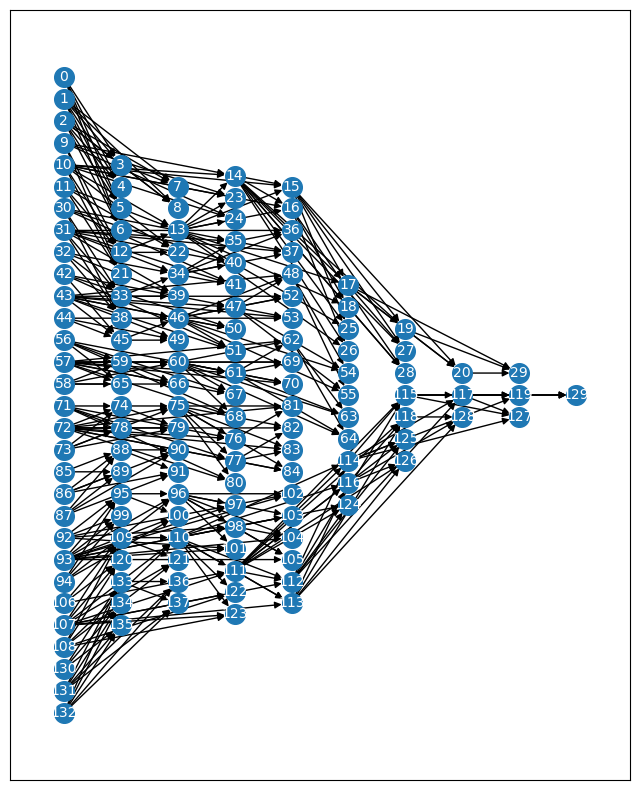

In [30]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(8,10))
nx.draw_networkx(G, pos, node_size=200, font_size=10, font_color='w')

In [75]:
import jax
import jax.numpy as jnp
from abc import ABC, abstractmethod
from typing import List

# we will abuse terminology and take frame and coordinate system to be roughly synonymous

class CoordinateSystem(ABC):
    @abstractmethod
    def to_local(self, coords):
        pass

    @abstractmethod
    def to_global(self, coords):
        pass

class AffineFrame(CoordinateSystem):
    def __init__(self, R, t, Ri=None):
        self.R = R # 3*3 
        self.Ri = jnp.linalg.inv(R) if Ri is None else Ri
        self.t = t # 3*1

    def to_local(self, coords):
        return jnp.einsum('...ik,...k->...i',
                          self.Ri, coords - self.t)

    def to_global(self, coords):
        """
        coords: n_batch * n_points * 3 
        """
        return self.t + jnp.einsum('...ik,...k->...i',
                                   self.R, coords)
    
    def _tree_flatten(self):
        children = (self.R, self.Ri, self.t)  # arrays / dynamic values
        aux_data = None
        return (children, aux_data)

    @classmethod
    def _tree_unflatten(cls, aux_data, children):
        R, Ri, t = children
        return cls(R=R, Ri=Ri, t=t)
    
from jax import tree_util
tree_util.register_pytree_node(AffineFrame,
                               AffineFrame._tree_flatten,
                               AffineFrame._tree_unflatten)
# class CartesianFrame(AffineFrame):
  
class SphericalFrame(CoordinateSystem):
    def __init__(self, permutation=[0,1,2]):
        self.permutation = permutation
        self.inverse = tuple(permutation.index(i) for i in range(len(permutation)))
        
    
    def to_local(self, coords):
        x, y, z = coords[..., 0:1], coords[..., 1:2], coords[..., 2:3]
        r = jnp.sqrt(x*x+y*y+z*z)
        theta = jnp.arctan2(y, x)
        phi = jnp.arccos(z/r)
        out = [r, theta, phi]
        return jnp.concatenate([out[i] for i in self.permutation], axis=-1)
    
    def to_global(self, coords):
        in_ = (coords[..., 0:1], coords[..., 1:2], coords[..., 2:3])
        r, theta, phi = (in_[i] for i in self.inverse)
        x = r * jnp.cos(theta) * jnp.sin(phi)
        y = r * jnp.sin(theta) * jnp.sin(phi)
        z = r * jnp.cos(phi)
        return jnp.concatenate([x, y, z], axis=-1)

    def _tree_flatten(self):
        children = self.permutation
        aux_data = None
        return (children, aux_data)

    @classmethod
    def _tree_unflatten(cls, aux_data, children):
        permutation = children
        return cls(permutation)

tree_util.register_pytree_node(SphericalFrame,
                               # lambda x: ((), x._tree_flatten()),
                               SphericalFrame._tree_flatten,
                               SphericalFrame._tree_unflatten)
def check_same_type(lst):
    if not lst:
        return True  # empty list is considered as having the same type
    first_type = type(lst[0])
    return all(type(item) == first_type for item in lst[1:])

def concatenate_leaves(trees, axis=1):
    # Define a helper function to recursively concatenate the arrays in the leaves of two PyTrees
    def concatenate_leaves_helper(tree1, tree2):
        if isinstance(tree1, (tuple, list)) and isinstance(tree2, (tuple, list)):
            # If both inputs are tuples or lists, concatenate the corresponding elements
            return type(tree1)(concatenate_leaves_helper(tree1[i], tree2[i]) for i in range(len(tree1)))
        elif isinstance(tree1, dict) and isinstance(tree2, dict):
            # If both inputs are dicts, recurse on each key
            return {k: concatenate_leaves_helper(tree1[k], tree2[k]) for k in tree1.keys()}
        elif isinstance(tree1, np.ndarray) and isinstance(tree2, np.ndarray):
            # If both inputs are ndarrays, concatenate them along the first axis
            return np.concatenate((tree1, tree2), axis=axis)
        else:
            raise ValueError('Inputs must have the same PyTree structure and contain ndarrays, tuples, or lists in the leaves.')

    # Define a function to reduce a list of PyTrees to a single concatenated PyTree
    def reduce_tree_list(trees):
        if len(trees) == 1:
            # If there is only one tree in the list, return it as is
            return trees[0]
        elif len(trees) == 2:
            # If there are two trees in the list, concatenate their leaves and return the result
            return concatenate_leaves_helper(trees[0], trees[1])
        else:
            # If there are more than two trees in the list, split it in half and recursively concatenate the halves
            split_idx = len(trees) // 2
            left_trees = trees[:split_idx]
            right_trees = trees[split_idx:]
            return concatenate_leaves([reduce_tree_list(left_trees), reduce_tree_list(right_trees)])

    # Call reduce_tree_list on the input list of trees to get the final concatenated PyTree
    return reduce_tree_list(trees)

# from jax.lib import pytree
def concatenate_trees(trees, axis=0):
    """
    Takes a list of trees and concatenates every corresponding leaf (assuming is array)
    Shallow concatenation, not recursive
    """
    leaves_list = []
    treedef_list = []
    for tree in trees:
        leaves, treedef = tree_flatten(tree)
        leaves_list.append(leaves)
        treedef_list.append(treedef)

    grouped_leaves = zip(*leaves_list)
    result_leaves = [jnp.concatenate(l, axis=axis) for l in grouped_leaves]
    return treedef_list[0].unflatten(result_leaves)

def concatenate_frames(frames: List[CoordinateSystem]) -> CoordinateSystem:
    # assert check_same_type(frames)
    return concatenate_trees(frames, axis=1)

def sort_frame(frame: CoordinateSystem, perm) -> CoordinateSystem:
    leaves, treedef = tree_flatten(frame)
    leaves_sorted = []
    for leave in leaves:
        leaves_sorted.append(leave[:, perm, ...])
    return treedef.unflatten(leaves_sorted)

In [76]:
from jax.tree_util import tree_flatten, tree_unflatten
def show_example(structured):
    flat, tree = tree_flatten(structured)
    unflattened = tree_unflatten(tree, flat)
    print(f"{structured=}\n  {flat=}\n  {tree=}\n  {unflattened=}")


In [94]:
from typing import Callable
from functools import partial
import numpy as np

def DAG_to_Z_indices(DAG: nx.DiGraph, n_atoms: int):
    """
    returns Z_indices: n_atoms * 4 array of masked Z index (zero for Cartesian repr-ed atom rows)
    """
    Z_indices = np.zeros((n_atoms, 4), dtype=np.int32)
    for (ref_atom_id, cur_atom_id, d) in DAG.edges(data=True):
        Z_indices[cur_atom_id, 1+d['id']] = ref_atom_id
        Z_indices[cur_atom_id, 0] = cur_atom_id
    return Z_indices

def DAG_to_Z_index_groups(DAG: nx.DiGraph):
    groups = []
    for layer, nodes in enumerate(nx.topological_generations(G)):
        n_atoms = len(nodes)
        Z_indices = np.zeros((n_atoms, 4), dtype=np.int32)
        for row_id, cur_atom_id in enumerate(nodes):
            if DAG.nodes[cur_atom_id]['layer'] == 0:
                Z_indices[row_id, 0] = cur_atom_id
                Z_indices[row_id, 1:] = -1
            else:
                for (ref_atom_id, _, d) in DAG.in_edges(cur_atom_id, data=True):
                    Z_indices[row_id, 1+d['id']] = ref_atom_id
                    Z_indices[row_id, 0] = cur_atom_id
        groups.append(Z_indices)
    return groups
            

# these are directly from Minhuan's code and wrapped with vmap
@jax.vmap
def dist(x1, x2):
    d = x2-x1
    d2 = jnp.sum(d*d, axis=2)
    return np.sqrt(d2)

@jax.vmap
def angle(x1, x2, x3, degrees=True):
    ba = x1 - x2
    ba /= jnp.linalg.norm(ba, axis=2, keepdims=True)
    bc = x3 - x2
    bc /= jnp.linalg.norm(bc, axis=2, keepdims=True)
    cosine_angle = jnp.sum(ba*bc, axis=2)
    if degrees:
        angle = jnp.degrees(np.arccos(cosine_angle)) # Range [0,180]
        return angle 
    else:  # Range [0, pi]
        return jnp.arccos(cosine_angle) 
    
@jax.vmap
def torsion(x1, x2, x3, x4):
    """Praxeolitic formula
    1 sqrt, 1 cross product"""
    b0 = -1.0*(x2 - x1)
    b1 = x3 - x2
    b2 = x4 - x3
    # normalize b1 so that it does not influence magnitude of vector
    # rejections that come next
    b1 /= jnp.linalg.norm(b1, axis=2, keepdims=True)

    # vector rejections
    # v = projection of b0 onto plane perpendicular to b1
    #   = b0 minus component that aligns with b1
    # w = projection of b2 onto plane perpendicular to b1
    #   = b2 minus component that aligns with b1
    v = b0 - jnp.sum(b0*b1, axis=2, keepdims=True) * b1
    w = b2 - jnp.sum(b2*b1, axis=2, keepdims=True) * b1

    # angle between v and w in a plane is the torsion angle
    # v and w may not be normalized but that's fine since tan is y/x
    x = jnp.sum(v*w, axis=2)
    b1xv = jnp.cross(b1, v, axisa=2, axisb=2)
    y = jnp.sum(b1xv*w, axis=2)
    return jnp.degrees(np.arctan2(y, x))

@jax.jit
def build_frame(x1, x2, x3):
    """
    x1, x2, x3 are the three atoms before x4, whose coordinate we want to express 
    in the local frame computed from x1, x2, x3. This algorithm is based on NeRF.
    
    x1: n_atoms * 3 array
    """
    bc = x3 - x2
    bc = bc / jnp.linalg.norm(bc, axis=-1, keepdims=True) # normalize
    
    n = jnp.cross(bc, x1-x2, axisa=-1, axisb=-1)
    n = n / jnp.linalg.norm(n, axis=-1, keepdims=True)
    
    nxbc = jnp.cross(n, bc, axisa=-1, axisb=-1)
    
    coordaxes = jnp.concatenate([nxbc[..., None], n[..., None], -bc[..., None]], axis=-1)
        
    return AffineFrame(R=coordaxes, t=x3[..., :])
    

ref_spherical_frame = SphericalFrame(permutation=(0,2,1))

class ICTransformation():
    
    def __init__(self, top: mdtraj.Topology, DAG: nx.DiGraph=None, 
                 conversion_scheme: Callable[mdtraj.Topology, nx.DiGraph]=None,
                 build_frame: Callable[[jnp.array, jnp.array, jnp.array], CoordinateSystem]=None):
        self.topology = top
        self.n_atoms = top.n_atoms
        self.DAG = DAG if DAG is not None else conversion_scheme(self.topology)
        self.Z_index_groups = DAG_to_Z_index_groups(self.DAG)
        self.flat_Z_indices = jnp.concatenate([Z_indices[..., 0] for Z_indices in self.Z_index_groups])
        self.ic_indices = jnp.array([i for i,n in self.DAG.nodes(data=True) if n['ic']==True], dtype=np.int32)
        self.n_groups = len(self.Z_index_groups)
        self.Z_index_group_sizes = [len(group) for group in self.Z_index_groups]
        self.build_frame = build_frame
    
    def get_frame_and_xyz_local(self, xyz):
        frame_lst = []
        xyz_transformed_lst = []

        for layer in range(self.n_groups):
            Z_indices = self.Z_index_groups[layer]
            positions = xyz[..., Z_indices[:, 0], :]
            if layer == 0:
                R0 = jnp.tile(jnp.eye(3)[None, None,...], (positions.shape[0], positions.shape[1], 1, 1))
                # assumes first layer start from the default global frame (Cartesian)
                frame = AffineFrame(R=R0, Ri=R0,
                                    t=jnp.zeros((positions.shape[0], positions.shape[1], 3)))
                xyz_transformed = positions
            else:
                frame = self.build_frame(xyz[..., Z_indices[:, 1], :], 
                                         xyz[..., Z_indices[:, 2], :], 
                                         xyz[..., Z_indices[:, 3], :]) # ref positions
            xyz_transformed = frame.to_local(positions)
            frame_lst.append(frame)
            xyz_transformed_lst.append(xyz_transformed)

        # stitch results from each layer into output
        frames = concatenate_frames(frame_lst)
        xyz_transformed = jnp.concatenate(xyz_transformed_lst, axis=1)

        perm = jnp.argsort(self.flat_Z_indices)
        frames = sort_frame(frames, perm)
        xyz_transformed = xyz_transformed[..., perm, :]
        return frames, xyz_transformed
        
    def get_frame_and_xyz_global(self, xyz):
        frame_lst = []

        for layer in range(self.n_groups):
            Z_indices = self.Z_index_groups[layer]
            positions = xyz[..., Z_indices[:, 0], :]
            if layer == 0:
                R0 = jnp.tile(jnp.eye(3)[None, None,...], (positions.shape[0], positions.shape[1], 1, 1))
                # assumes first layer start from the default global frame (Cartesian)
                frame = AffineFrame(R=R0, Ri=R0,
                                    t=jnp.zeros((positions.shape[0], positions.shape[1], 3)))
                xyz_transformed = positions
            else:
                frame = self.build_frame(xyz[..., Z_indices[:, 1], :], 
                                         xyz[..., Z_indices[:, 2], :], 
                                         xyz[..., Z_indices[:, 3], :]) # ref positions
                xyz_transformed = frame.to_global(positions)
            frame_lst.append(frame)
            xyz = xyz.at[..., Z_indices[:, 0], :].set(xyz_transformed)

        # stitch results from each layer into output
        frames = concatenate_frames(frame_lst)
        perm = jnp.argsort(self.flat_Z_indices)
        frames = sort_frame(frames, perm)
        return frames, xyz
    
    def xyz2ic(self, xyz: jnp.array, vec_angles=False):
        """
        xyz : n_batch * n_atoms * 3 array of Cartesian coordinates
        """
        
        frames, xyz_local = self.get_frame_and_xyz_local(xyz)
        
        # convert some to IC coordinates
        ic = xyz_local.at[..., self.ic_indices, :].set(\
            ref_spherical_frame.to_local(xyz_local[..., self.ic_indices, :])
        )
                
        if vec_angles:
            pass
        
        return frames, ic
            
    # need to deal with pure IC repr later
    def ic2xyz(self, ic):
        """
        ic: n_batch * n_atoms * 3 array of mixed coordinates 
        (Cartesian coordinates are used to initialize computation)
        """
        xyz_local = ic.at[..., self.ic_indices, :].set(\
            ref_spherical_frame.to_global(ic[..., self.ic_indices, :])
        )
        
        frames, xyz = self.get_frame_and_xyz_global(xyz_local)
        return frames, xyz

In [95]:
ict = ICTransformation(top=top, DAG=G, build_frame=build_frame)

In [96]:
xyz_0 = jnp.tile(jnp.array(traj.xyz), (1, 1, 1))
print(xyz_0.shape)
frames_local, ic = ict.xyz2ic(xyz_0)
frames_global, xyz = ict.ic2xyz(ic)

(18, 138, 3)


In [97]:
import deeprefine
import torch
converter = deeprefine.ICConverter(top, vec_angles=False)
xyz_0_torch = torch.Tensor(traj.xyz.reshape(18, -1))
ic_torch = converter.xyz2ic(xyz0).reshape(18, -1, 3)

In [129]:
[atoms[i] for i in  [ 25,  13,  14,  15]]

[TYR2-HD1, TYR2-CB, TYR2-CG, TYR2-CD1]

In [120]:
ict.flat_Z_indices[114]

Array(25, dtype=int32)

In [128]:
ict.Z_index_groups[5]

array([[ 17,  13,  14,  15],
       [ 25,  13,  14,  15],
       [ 18,  13,  14,  16],
       [ 26,  13,  14,  16],
       [ 54,  46,  47,  48],
       [ 55,  46,  47,  48],
       [ 63,  60,  61,  62],
       [ 64,  60,  61,  62],
       [124, 110, 111, 112],
       [114, 110, 111, 112],
       [116, 110, 111, 113]], dtype=int32)

In [130]:
ic[0][ict.flat_Z_indices,:][114]

Array([ 0.10789938,  2.0943394 , -0.00510015], dtype=float32)

In [133]:
ic_torch.shape

torch.Size([18, 138, 3])

In [134]:
ic_torch[0, 114, :]

tensor([ 0.1400,  2.0933, -3.1384])

In [104]:
ic[0][ict.flat_Z_indices,:] - jnp.array(ic_torch[0])

Array([[ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
       [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
       [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
       [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
       [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
       [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
       [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
       [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
       [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
       [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
       [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
       [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
       [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
       [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
       [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
       [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
       [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
       [ 0.0000000e+00,  0.0000

In [107]:
jnp.where(jnp.isclose(ic[0][ict.flat_Z_indices,:], jnp.array(ic_torch[0]),atol=1e-5)==False)

(Array([114, 114, 114, 115, 115, 115], dtype=int32),
 Array([0, 1, 2, 0, 1, 2], dtype=int32))

In [111]:
atoms[115]

TRP9-CE2

In [60]:
test_xyz2ic = lambda: ict.xyz2ic(xyz_0)
test_ic2xyz = lambda: ict.ic2xyz(ic)
_ =test_xyz2ic()
_ =test_ic2xyz()

In [61]:
%%timeit
test_xyz2ic()

180 ms ± 333 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [62]:
%%timeit
test_ic2xyz()

205 ms ± 1.97 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [146]:
# import cProfile

cProfile.run('test_xyz2ic()', 'xyz2ic_stats')

In [705]:
cProfile.run('test_ic2xyz()', 'ic2xyz_stats')

In [714]:
import pstats
from pstats import SortKey
p = pstats.Stats('ic2xyz_stats')
p.strip_dirs().sort_stats(SortKey.CUMULATIVE).print_stats(20)

Fri Apr 21 22:57:53 2023    ic2xyz_stats

         165411 function calls (164662 primitive calls) in 0.238 seconds

   Ordered by: cumulative time
   List reduced from 476 to 20 due to restriction <20>

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.000    0.000    0.240    0.240 {built-in method builtins.exec}
        1    0.000    0.000    0.240    0.240 <string>:1(<module>)
        1    0.000    0.000    0.240    0.240 3224289598.py:2(<lambda>)
        1    0.000    0.000    0.240    0.240 4148806271.py:189(ic2xyz)
        1    0.001    0.001    0.213    0.213 4148806271.py:145(get_frame_and_xyz_global)
       81    0.001    0.000    0.162    0.002 array.py:323(__getitem__)
       81    0.001    0.000    0.161    0.002 lax_numpy.py:3862(_rewriting_take)
       81    0.001    0.000    0.148    0.002 lax_numpy.py:3914(_gather)
       92    0.005    0.000    0.134    0.001 lax_numpy.py:4015(_index_to_gather)
      432    0.001    0.000    0.104  

In [710]:
p = pstats.Stats('xyz2ic_stats')
p.strip_dirs().sort_stats(SortKey.CUMULATIVE).print_stats(20)

Fri Apr 21 22:57:52 2023    xyz2ic_stats

         47201 function calls (47059 primitive calls) in 0.101 seconds

   Ordered by: cumulative time
   List reduced from 476 to 20 due to restriction <20>

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.000    0.000    0.101    0.101 {built-in method builtins.exec}
        1    0.000    0.000    0.101    0.101 <string>:1(<module>)
        1    0.000    0.000    0.101    0.101 3224289598.py:1(<lambda>)
        1    0.000    0.000    0.101    0.101 4148806271.py:171(xyz2ic)
        1    0.001    0.001    0.086    0.086 4148806271.py:115(get_frame_and_xyz_local)
       36    0.000    0.000    0.050    0.001 array.py:323(__getitem__)
       36    0.001    0.000    0.049    0.001 lax_numpy.py:3862(_rewriting_take)
       36    0.000    0.000    0.044    0.001 lax_numpy.py:3914(_gather)
        9    0.005    0.001    0.043    0.005 4148806271.py:78(build_frame)
      103    0.000    0.000    0.037    0.000 c

In [79]:
list(top.atoms)[:10]

[GLY1-N,
 GLY1-CA,
 GLY1-C,
 GLY1-O,
 GLY1-H,
 GLY1-H2,
 GLY1-H3,
 GLY1-HA2,
 GLY1-HA3,
 TYR2-N]

In [69]:
list(list(top.residues)[0].atoms)

[GLY1-N, GLY1-CA, GLY1-C, GLY1-O, GLY1-H, GLY1-H2, GLY1-H3, GLY1-HA2, GLY1-HA3]

In [68]:
ict.Z_indices

array([[  0.,   0.,   0.,   0.],
       [  0.,   0.,   0.,   0.],
       [  0.,   0.,   0.,   0.],
       [  3.,   2.,   1.,   0.],
       [  4.,   0.,   1.,   2.],
       [  0.,   0.,   0.,   0.],
       [  0.,   0.,   0.,   0.],
       [  7.,   1.,   2.,   3.],
       [  8.,   1.,   2.,   3.],
       [  0.,   0.,   0.,   0.],
       [  0.,   0.,   0.,   0.],
       [  0.,   0.,   0.,   0.],
       [ 12.,  11.,  10.,   9.],
       [ 13.,  10.,  11.,  12.],
       [ 14.,  13.,  10.,   9.],
       [ 15.,  14.,  13.,  10.],
       [ 16.,  14.,  13.,  10.],
       [ 17.,  15.,  14.,  13.],
       [ 18.,  16.,  14.,  13.],
       [ 19.,  17.,  15.,  14.],
       [ 20.,  19.,  17.,  15.],
       [ 21.,   9.,  10.,  11.],
       [ 22.,  10.,  11.,  12.],
       [ 23.,  13.,  10.,   9.],
       [ 24.,  13.,  10.,   9.],
       [ 25.,  15.,  14.,  13.],
       [ 26.,  16.,  14.,  13.],
       [ 27.,  17.,  15.,  14.],
       [ 28.,  18.,  16.,  14.],
       [ 29.,  20.,  19.,  17.],
       [  

In [86]:
traj.xyz[ict.Z_indices[None, ...]].shape

IndexError: index 18 is out of bounds for axis 0 with size 18

In [85]:
ict.Z_indices[None, ...].shape

(1, 138, 4)